# Imports e carregamentos

In [39]:
import pandas as pd

import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [40]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

In [41]:
df.value_counts('result')

result
0    538973
1    178469
Name: count, dtype: int64

In [42]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'shotsHome', 'shotsAway', 'league',
       'corners_home', 'shotsOffgoal_home', 'shotsOffgoal_away',
       'shotsOngoal_home', 'fouls_home', 'fouls_away', 'tackles_home',
       'tackles_away', 'result', 'match_id', 'possessiontime_away',
       'possessiontime_home', 'shotsOnGoalEfficiency', 'attackPressure',
       'shotAccuracy_home', 'shotAccuracy_away', 'possessionControl',
       'passRiskHome', 'passRiskAway', 'defensiveDiscipline',
       'defensiveEfficacy', 'defensiveAggression',
       'timeSinceLastEventShots_Home', 'timeSinceLastEventShots_Away',
       'timeSinceLastEventCorners_Home', 'timeSinceLastEventCorners_Away',
       'timeSinceLastEvent_Home', 'timeSinceLastEvent_Away',
       'timeSinceLastEventFouls_Home', 'timeSinceLastEventFouls_Away',
       'timeSinceLastEventTotalCards_Home',
       'timeSinceLastEventTotalCards_Away', 'total_change_possessiontime_home',
       'total_change_possessiontime_away', '05ht_home', '05ft

In [27]:
df[df['homeTeam'] == 'SC Corinthians Paulista']['05ht_home'].tail(1).values[0]

0.5

In [37]:
from rapidfuzz import fuzz
import numpy as np
import pandas as pd

# Função para calcular a similaridade (usando RapidFuzz)
def calculate_similarity_fast(vector, reference):
    return np.array([fuzz.ratio(reference, x) for x in vector])

# String de referência
string_referencia = "Corinthians"

# Aplicando a função otimizada
df['similaridade'] = calculate_similarity_fast(df['homeTeam'], string_referencia)

# Encontrando a string com a maior similaridade
string_mais_similar = df.loc[df['similaridade'].idxmax()]

print(string_mais_similar['homeTeam'])


SC Corinthians Paulista


## Preprocessamento

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    return preprocessor.fit(X)
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)

# Salvando o preprocessador para uso futuro
pickle.dump(preprocessor, open('../models/preprocessor.pickle', 'wb'))

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)


In [35]:
X_train.shape[1]

76

                                                                                  
Generation 1 - Current best internal CV score: 0.7634048480730643
                                                                                  
Generation 2 - Current best internal CV score: 0.7634048480730643
                                                                                  
Generation 3 - Current best internal CV score: 0.7773857445674289
                                                                                
Generation 4 - Current best internal CV score: 0.7773857445674289
                                                             
Generation 5 - Current best internal CV score: 0.7836308307989904
                                                             
Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)


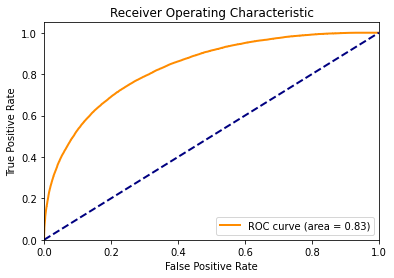

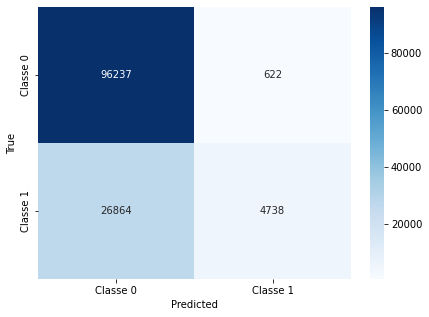

Relatório de Classificação:
               precision    recall  f1-score   support

    Classe 0       0.78      0.99      0.88     96859
    Classe 1       0.88      0.15      0.26     31602

    accuracy                           0.79    128461
   macro avg       0.83      0.57      0.57    128461
weighted avg       0.81      0.79      0.72    128461



In [6]:
from tpot import TPOTClassifier
from sklearn.metrics import classification_report

# Inicializando TPOT
tpot = TPOTClassifier(n_jobs=2, generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# Salvando o pipeline otimizado
# tpot.export('tpot_exported_pipeline.py')

# Salvar o modelo TPOT
with open('../models/tpot_model.pkl', 'wb') as file:
    pickle.dump(tpot.fitted_pipeline_, file)

# Avaliação do Modelo
y_pred_prob = tpot.predict_proba(X_test)[:, 1]  # pegar as probabilidades da classe 1
y_pred = tpot.predict(X_test)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Visualizar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Visualizar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, target_names=['Classe 0', 'Classe 1']))


In [54]:
# from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


# num_negatives = 96859  # Soma da coluna da Classe 0
# num_positives = 31602  # Soma da coluna da Classe 1
num_negatives = 107844  # Soma da coluna da Classe 0
num_positives = 35645  # Soma da coluna da Classe 1

scale_pos_weight = num_negatives / num_positives

xgb_model = XGBClassifier(learning_rate=1.0, max_depth=10, min_child_weight=7, n_estimators=200, n_jobs=-1, subsample=0.6000000000000001, random_state=42, scale_pos_weight=scale_pos_weight)

# Treinar o modelo ajustado
xgb_model.fit(X_train, y_train)

# Fazer previsões
y_pred = xgb_model.predict(X_test)

# Avaliar o modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[101145   6699]
 [  4794  30851]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95    107844
           1       0.82      0.87      0.84     35645

    accuracy                           0.92    143489
   macro avg       0.89      0.90      0.89    143489
weighted avg       0.92      0.92      0.92    143489



In [48]:
X_test.shape[0]

143489

In [55]:
# salvar modelo xgboost
with open('../models/tpot_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)



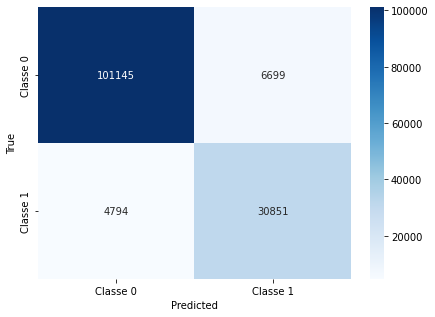

Relatório de Classificação:
               precision    recall  f1-score   support

    Classe 0       0.95      0.94      0.95    107844
    Classe 1       0.82      0.87      0.84     35645

    accuracy                           0.92    143489
   macro avg       0.89      0.90      0.89    143489
weighted avg       0.92      0.92      0.92    143489



In [56]:
# Fazendo previsões
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# # Curva ROC
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)

# # Visualizando a curva ROC
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Visualizando a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de Classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, target_names=['Classe 0', 'Classe 1']))

In [9]:



# # Inicializando o modelo XGBClassifier
# xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, verbosity=1)

# # Definindo os parâmetros para a busca em grade
# parameters = {
#     'max_depth': [8, 9, 10],
#     'learning_rate': [0.1, 0.5, 1],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.3, 0.5, 0.7],
#     'min_child_weight': [1, 5, 10]
# }

# # Configurando a busca em grade com validação cruzada
# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=parameters,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=3,
#     verbose=2
# )

# # Executando a busca em grade no conjunto de dados de treino
# # X_train, y_train = ...
# grid_search.fit(X_train, y_train)

# # Melhores parâmetros e melhor pontuação
# best_parameters = grid_search.best_params_
# best_score = grid_search.best_score_

# print('Melhores parâmetros:', best_parameters)
# print('Melhor pontuação AUC:', best_score)

# # Treinar o modelo com os melhores parâmetros encontrados
# best_xgb = XGBClassifier(**best_parameters)
# best_xgb.fit(X_train, y_train)

In [25]:
df['result'].head(1699).tail(1)

1698    0
Name: result, dtype: int64

In [22]:
# model_Automl = pickle.load(open('../models/tpot_model.pkl', 'rb'))
model_Automl = pickle.load(open('../models/tpo_model.pkl', 'rb'))

# # na prática
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
yht = df['result'].head(1699).tail(1)

model_Automl.predict(Xht)[0]  # pegar as probabilidades da classe 1

0

In [12]:
# model_Automl = pickle.load(open('../models/tpot_model.pkl', 'rb'))
# from sklearn.metrics import accuracy_score

# # avaliando treino e teste
# y_pred_prob = model_Automl.predict_proba(X_train)[:, 1]  # pegar as probabilidades da classe 1
# y_pred = model_Automl.predict(X_train)
# print('Acurácia treino:', accuracy_score(y_train, y_pred))

# y_pred_prob = model_Automl.predict_proba(X_test)[:, 1]  # pegar as probabilidades da classe 1
# y_pred = model_Automl.predict(X_test)
# print('Acurácia teste:', accuracy_score(y_test, y_pred))

